# Ensemble learning

In [5]:
from typing import List, Type, Union

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

from sklearn.datasets import fetch_openml
from sklearn.base import ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier

## Zbiór danych

W zadaniu poddany analizie będzie dobrze już znany zbiór MNIST.

In [36]:
mnist = fetch_openml("mnist_784", data_home="./mnist_784", cache=True)

In [37]:
X = mnist.data[:10000]
y = mnist.target[:10000]

## Transformacja zbioru do przestrzeni 30D

In [38]:
standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(X)

pca = PCA(30)
X_pca = pca.fit_transform(X_scaled)

## Wybór trudno rozdzielalnych cech

W celu znalezienia trudno rozróżnialnych cech zbioru możemy skorzystać z metody t-SNE.

In [39]:
X_embedded = TSNE(n_components=2).fit_transform(X_pca)
X_embedded.shape

(10000, 2)

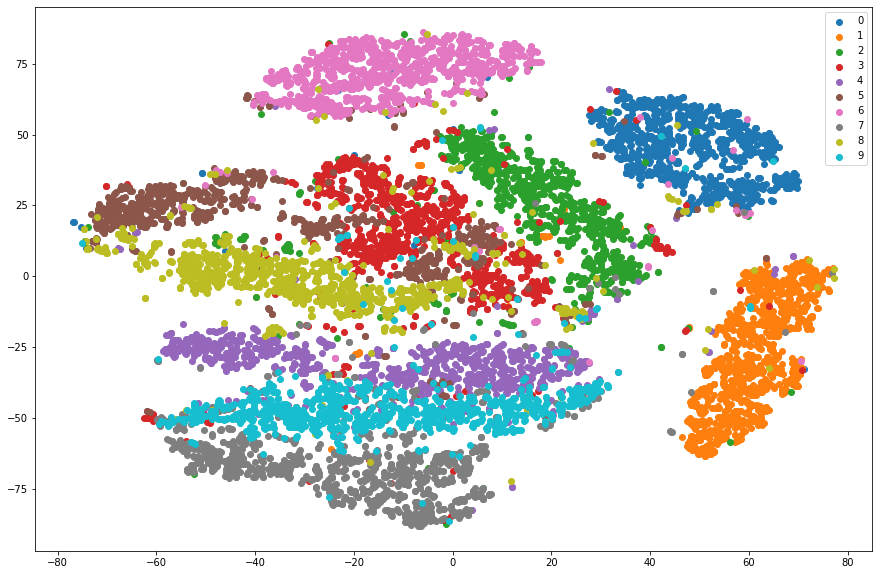

In [40]:
ids = [str(i) for i in range(10)]
plt.figure(figsize=(15, 10))

for c, label in zip(mcolors.TABLEAU_COLORS, ids):
    plt.scatter(X_embedded[y == label, 0], X_embedded[y == label, 1], c=c, label=label)
plt.legend()
plt.show()

Wyraźnie widać zgrupowanie klasy 4 i 9. Użyjemy ich w dalszej części zadania.

In [41]:
digit_filter = np.where((y == '4') | (y == '9'))
X_filtered, y_filtered = X_pca[digit_filter], y[digit_filter]

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=13)

In [43]:
X_train.shape

(1566, 30)

## Bagging

W zależności od sposobu wyboru podzbiorów zbioru danych wyróżniamy różne rodzaje tego algorytmu:

- **pasting** - wybór losowych podzbiorów próbek
- **bagging** - wybór losowych podzbiorów próbek ze zwracaniem
- **random subspaces** - wybór losowych podzbiorów cech
- **random patches** - wybór losowych podzbiorów próbek i cech

W praktyce wybór metody sprowadza się do odpowiedniego ustawienia zmiennych w klasyfikatorze BaggingClassifier.
Szczegółowy opis można znaleźć w [dokumentacji](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) sklearn.

#### Klasyczny bagging

Jak zostało wyżej wspomniane - w tej metodzie wybieramy losowo podzbory próbek ze zwracaniem. Jest to domyślny wariant klasyfikatora BaggingClassifier.

In [9]:
clf = BaggingClassifier(base_estimator=SVC(),
                        n_estimators=5,
                        max_samples=0.5).fit(X_train, y_train)

In [10]:
clf.score(X_test, y_test)

0.9770408163265306

Metody grupowania są silnie uzależnione od ilości klasyfikatorów oraz ilości próbek, których użyjemy do ich trenowania. Możemy w prosty sposób zwizualizować tą zależność:

In [11]:
def ensemble_scores(clf, estimators, samples, base_estimator=None):
    for n_estimators in estimators:
        for max_samples in samples:
            fitted_clf = clf(base_estimator=base_estimator,
                             n_estimators=n_estimators,
                             max_samples=max_samples).fit(X_train, y_train)
            yield n_estimators, max_samples, fitted_clf.score(X_test, y_test)

            
def visualize_ensemble(clf, n_estimators, max_samples, base_estimator=None):
    values = np.array(list(ensemble_scores(clf, n_estimators, max_samples, base_estimator)))
    X = values[:,0]
    Y = values[:,1]
    Z = values[:,2]
    
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection='3d')
    ax.plot_trisurf(X, Y, Z, linewidth=0, antialiased=True, cmap='viridis')

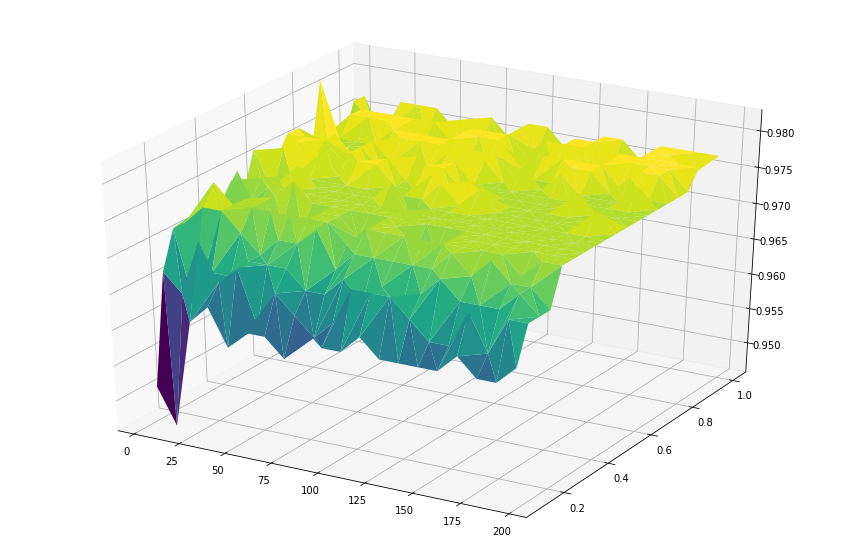

In [12]:
estimators = np.arange(5, 200, 10)
samples = np.linspace(0.1, 1., num=20)

visualize_ensemble(BaggingClassifier, estimators, samples, base_estimator=SVC())

#### Random subspace

Metoda random subspace od zwykłego baggingu różni się tym, że wybieramy podzbiory cech zamiast podzbiorów próbek. Ustawiamy flagi:
- **bootstrap_features=True** - wybieramy cechy ze zwracaniem
- **max_samples=1.0 (default)** - nie losujemy próbek (bierzemy wszystkie)
- **max_features=n** - ilość losowanych cech

In [132]:
clf = BaggingClassifier(base_estimator=SVC(),
                        n_estimators=5,
                        bootstrap_features=True,
                        max_features=0.5).fit(X_train, y_train)

In [133]:
clf.score(X_test, y_test)

0.9566326530612245

#### Random patching

Połączenie powyższych metod nazywamy _random patching_. Ze zbioru losujemy i próbki, i cechy.

In [127]:
clf = BaggingClassifier(base_estimator=SVC(),
                        n_estimators=5,
                        bootstrap_features=True,
                        max_features=0.5,
                        max_samples=0.6).fit(X_train, y_train)

In [131]:
clf.score(X_test, y_test)

0.9209183673469388

### Zadanie
1. Zwizualizuj za pomocą tabeli zależność powyższych metod od *n_estimators* i *max_samples*/*max_features*.
2. Odpowiedz na pytanie: jak zmienia się dokładność klasyfikacji dla różnych metod określana finalnej decyzji (normalna średnia, majority vote, etc.)

In [1]:
import pandas as pd

In [44]:
def ensemble_scores_full(clf, estimators, features, samples, base_estimator=None):
    for n_estimators in estimators:
        for max_features in features:
            for max_samples in samples:
                fitted_clf = clf(base_estimator=base_estimator,
                             n_estimators=n_estimators,
                             bootstrap_features=True,
                             max_features=max_features).fit(X_train, y_train)
                yield n_estimators, max_features, max_samples, fitted_clf.score(X_test, y_test)


def visualize_ensemble_table(clf, n_estimators, features, samples, base_estimator=None):
    values = np.array(list(ensemble_scores_full(clf, n_estimators, features, samples, base_estimator)))
    dt = pd.DataFrame()
    dt["n_estimators"] = values[:,0]
    dt["max_features"] = values[:,1]
    dt["max_samples"] = values[:,2]
    dt["accuracy"] = values[:,3]
    return dt            

In [45]:
estimators = np.arange(5, 100, 10)
features = np.linspace(0.1, 1., num=6)
samples = np.linspace(0.1, 1., num=6)

In [46]:
df = pd.DataFrame()
df["n_estimators/max_features"] = estimators
for max_features in features:
    scores = []
    for n_estimators in estimators:    
            fitted_clf = BaggingClassifier(base_estimator=SVC(),
                             n_estimators=n_estimators,
                             bootstrap_features=True,
                             max_features=max_features).fit(X_train, y_train)
            scores.append(fitted_clf.score(X_test, y_test))
    df["{0}".format(round(max_features,2))]=scores
df            

,n_estimators/max_features,0.1,0.28,0.46,0.64,0.82,1.0
0,5,0.788265,0.908163,0.943878,0.964286,0.971939,0.969388
1,15,0.844388,0.895408,0.948980,0.964286,0.974490,0.977041
2,25,0.864796,0.933673,0.959184,0.971939,0.971939,0.971939
3,35,0.895408,0.946429,0.966837,0.974490,0.971939,0.974490
4,45,0.877551,0.946429,0.969388,0.969388,0.974490,0.974490
5,55,0.862245,0.946429,0.966837,0.971939,0.977041,0.974490
6,65,0.897959,0.943878,0.961735,0.977041,0.977041,0.974490
7,75,0.887755,0.959184,0.956633,0.977041,0.974490,0.977041
8,85,0.920918,0.954082,0.961735,0.969388,0.969388,0.977041
9,95,0.897959,0.948980,0.959184,0.974490,0.971939,0.974490


In [47]:
dfs = pd.DataFrame()
dfs["n_estimators/max_samples"] = estimators
for max_samples in samples:
    scores = []
    for n_estimators in estimators:    
            fitted_clf = BaggingClassifier(base_estimator=SVC(),
                             n_estimators=n_estimators,
                             bootstrap_features=True,
                             max_features=0.5,
                             max_samples=max_samples).fit(X_train, y_train)
            scores.append(fitted_clf.score(X_test, y_test))
    dfs["{0}".format(round(max_samples,2))]=scores
dfs

,n_estimators/max_samples,0.1,0.28,0.46,0.64,0.82,1.0
0,5,0.923469,0.943878,0.941327,0.948980,0.946429,0.938776
1,15,0.923469,0.948980,0.964286,0.959184,0.956633,0.948980
2,25,0.936224,0.938776,0.951531,0.956633,0.964286,0.971939
3,35,0.946429,0.959184,0.943878,0.964286,0.964286,0.966837
4,45,0.941327,0.956633,0.964286,0.961735,0.969388,0.974490
5,55,0.946429,0.956633,0.961735,0.964286,0.966837,0.966837
6,65,0.961735,0.956633,0.961735,0.964286,0.966837,0.974490
7,75,0.954082,0.964286,0.956633,0.961735,0.959184,0.966837
8,85,0.959184,0.961735,0.959184,0.966837,0.966837,0.966837
9,95,0.946429,0.954082,0.961735,0.966837,0.966837,0.964286


In [48]:
pdf = pd.DataFrame()
pdf["n_estimators/max_features"] = estimators
for max_features in features:
    scores = []
    for n_estimators in estimators:    
            fitted_clf = BaggingClassifier(base_estimator=SVC(probability=True),
                             n_estimators=n_estimators,
                             bootstrap_features=True,
                             max_features=max_features).fit(X_train, y_train)
            scores.append(fitted_clf.score(X_test, y_test))
    pdf["{0}".format(round(max_features,2))]=scores
pdf            

,n_estimators/max_features,0.1,0.28,0.46,0.64,0.82,1.0
0,5,0.831633,0.923469,0.948980,0.941327,0.971939,0.971939
1,15,0.880102,0.941327,0.959184,0.969388,0.961735,0.974490
2,25,0.900510,0.931122,0.959184,0.966837,0.966837,0.974490
3,35,0.923469,0.948980,0.969388,0.974490,0.977041,0.974490
4,45,0.900510,0.948980,0.959184,0.971939,0.971939,0.971939
5,55,0.897959,0.954082,0.964286,0.971939,0.977041,0.977041
6,65,0.946429,0.951531,0.959184,0.966837,0.977041,0.974490
7,75,0.892857,0.943878,0.959184,0.969388,0.974490,0.971939
8,85,0.936224,0.954082,0.969388,0.966837,0.974490,0.974490
9,95,0.885204,0.956633,0.966837,0.971939,0.971939,0.974490


In [49]:
pdfs = pd.DataFrame()
pdfs["n_estimators/max_samples"] = estimators
for max_samples in samples:
    scores = []
    for n_estimators in estimators:    
            fitted_clf = BaggingClassifier(base_estimator=SVC(probability=True),
                             n_estimators=n_estimators,
                             bootstrap_features=True,
                             max_features=0.5,
                             max_samples=max_samples).fit(X_train, y_train)
            scores.append(fitted_clf.score(X_test, y_test))
    pdfs["{0}".format(round(max_samples,2))]=scores
pdfs

,n_estimators/max_samples,0.1,0.28,0.46,0.64,0.82,1.0
0,5,0.936224,0.936224,0.956633,0.956633,0.943878,0.971939
1,15,0.951531,0.954082,0.943878,0.959184,0.956633,0.959184
2,25,0.948980,0.959184,0.961735,0.959184,0.961735,0.964286
3,35,0.946429,0.961735,0.961735,0.961735,0.959184,0.961735
4,45,0.948980,0.954082,0.959184,0.969388,0.964286,0.971939
5,55,0.941327,0.959184,0.956633,0.966837,0.964286,0.964286
6,65,0.946429,0.961735,0.956633,0.956633,0.964286,0.961735
7,75,0.951531,0.956633,0.961735,0.961735,0.964286,0.966837
8,85,0.956633,0.956633,0.956633,0.959184,0.956633,0.969388
9,95,0.954082,0.954082,0.961735,0.964286,0.971939,0.964286


## Random Forest


Metoda Random Forest różni się od baggingu przede wszystkim tym, że cechy wybierane są losowo spośród wszystkich i najlepszy podział z podzbioru zostaje użyty do dzielenia węzłów w drzewie.
W baggingu natomiast podczas dzielenia węzłów bierze się pod uwagę wszystkie cechy.

Szczegółowy opis znajduje się w [dokumentacji](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) sklearn.

In [14]:
clf = RandomForestClassifier(n_estimators=5,
                             max_samples=0.5).fit(X_train, y_train)

In [15]:
clf.score(X_test, y_test)

0.9209183673469388

## Ada Boost

Metoda, która agreguje wiele słabszych klasyfikatorów w jeden większy. W odróżnieniu od baggingu waga drzew nie jest jednakowa.

Szczegółowy opis znajduje się w [dokumentacji](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html?highlight=adaboost#sklearn.ensemble.AdaBoostClassifier) sklearn.

In [16]:
clf = AdaBoostClassifier(n_estimators=5).fit(X_train, y_train)

In [17]:
clf.score(X_test, y_test)

0.8163265306122449

## Projekt indywidualny


Dokonaj analizy zbioru danych FMNIST za pomocą wyżej wymienionych klasyfikatorów.

In [10]:
fmnist = fetch_openml("Fashion-MNIST", data_home="./fmnist", cache=True)

1. Ze zbioru wybierz dwie trudno rozdzielalne cechy i wykorzystaj je do dalszej analizy.
2. Sprawdź wydajność klasyfikatorów Bagging, RandomForest i AdaBoost dla powstałego zbioru.
3. Dla każdego zbioru sprawdź zależność wyniku od ilości klasyfikatorów bazowych. Zaprezentuj wyniki w tabelce. 

#### 1

In [11]:
X = fmnist.data[:10000]
y = fmnist.target[:10000]

standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(X)

pca = PCA(60)
X_pca = pca.fit_transform(X_scaled)

X_embedded = TSNE(n_components=2).fit_transform(X_pca)
X_embedded.shape

(10000, 2)

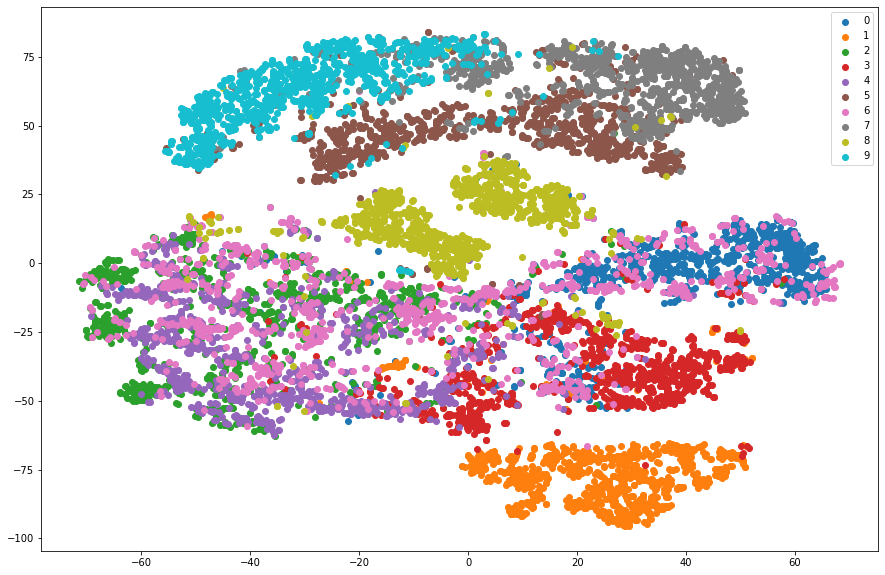

In [12]:
ids = [str(i) for i in range(10)]
plt.figure(figsize=(15, 10))

for c, label in zip(mcolors.TABLEAU_COLORS, ids):
    plt.scatter(X_embedded[y == label, 0], X_embedded[y == label, 1], c=c, label=label)
plt.legend()
plt.show()

In [13]:
fltr = np.where((y == '4') | (y == '6'))
X_filtered, y_filtered = X_pca[fltr], y[fltr]

#### 2

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=22)

In [15]:
n_estimators = [5, 10, 20, 30, 50, 100, 200, 300]

In [16]:
def AdaBoost(X_train, X_test, y_train, y_test, n_estimators):
    clf = AdaBoostClassifier(n_estimators=n_estimators).fit(X_train, y_train)
    return clf.score(X_test, y_test)

In [17]:
def RandomForest(X_train, X_test, y_train, y_test, n_estimators):
    clf = RandomForestClassifier(n_estimators=n_estimators).fit(X_train, y_train)
    return clf.score(X_test, y_test)

In [18]:
def Bagging(X_train, X_test, y_train, y_test, n_estimators):
    clf = BaggingClassifier(n_estimators=n_estimators, max_samples=0.5).fit(X_train, y_train)
    return clf.score(X_test, y_test)

In [19]:
df = pd.DataFrame()
df["Classifier"] = ["Bagging", "RandomForest", "AdaBoost"]

for n in n_estimators:
    df["n_estimators={0}".format(n)] = [Bagging(X_train, X_test, y_train, y_test, n), 
                      RandomForest(X_train, X_test, y_train, y_test, n),
                      AdaBoost(X_train, X_test, y_train, y_test, n)]

In [20]:
df

,Classifier,n_estimators=5,n_estimators=10,n_estimators=20,n_estimators=30,n_estimators=50,n_estimators=100,n_estimators=200,n_estimators=300
0,Bagging,0.822055,0.862155,0.852130,0.864662,0.884712,0.872180,0.874687,0.867168
1,RandomForest,0.812030,0.854637,0.884712,0.872180,0.874687,0.887218,0.877193,0.884712
2,AdaBoost,0.802005,0.819549,0.834586,0.832080,0.852130,0.839599,0.854637,0.859649


#### 3

In [21]:
def ensemble_scores_full(clf, estimators, features, samples, base_estimator=None):
    for n_estimators in estimators:
        for max_features in features:
            for max_samples in samples:
                fitted_clf = clf(base_estimator=base_estimator,
                             n_estimators=n_estimators,
                             bootstrap_features=True,
                             max_features=max_features).fit(X_train, y_train)
                yield n_estimators, max_features, max_samples, fitted_clf.score(X_test, y_test)


def visualize_ensemble_table(clf, n_estimators, features, samples, base_estimator=None):
    values = np.array(list(ensemble_scores_full(clf, n_estimators, features, samples, base_estimator)))
    dt = pd.DataFrame()
    dt["n_estimators"] = values[:,0]
    dt["max_features"] = values[:,1]
    dt["max_samples"] = values[:,2]
    dt["accuracy"] = values[:,3]
    return dt  

In [22]:
estimators = np.arange(5, 100, 10)
features = np.linspace(0.1, 1., num=6)
samples = np.linspace(0.1, 1., num=6)

In [31]:
df = pd.DataFrame()
df["n_estimators/max_features"] = estimators
for max_features in features:
    scores = []
    for n_estimators in estimators:    
            fitted_clf = BaggingClassifier(base_estimator=SVC(),
                             n_estimators=n_estimators,
                             bootstrap_features=True,
                             max_features=max_features).fit(X_train, y_train)
            scores.append(fitted_clf.score(X_test, y_test))
    df["{0}".format(round(max_features,2))]=scores
df            

,n_estimators/max_features,0.1,0.28,0.46,0.64,0.82,1.0
0,5,0.817043,0.877193,0.897243,0.899749,0.887218,0.889724
1,15,0.852130,0.857143,0.902256,0.889724,0.894737,0.892231
2,25,0.867168,0.877193,0.892231,0.889724,0.897243,0.889724
3,35,0.857143,0.892231,0.892231,0.899749,0.897243,0.897243
4,45,0.872180,0.887218,0.889724,0.899749,0.899749,0.902256
5,55,0.877193,0.887218,0.887218,0.897243,0.902256,0.897243
6,65,0.867168,0.879699,0.887218,0.899749,0.899749,0.899749
7,75,0.869674,0.879699,0.894737,0.899749,0.897243,0.897243
8,85,0.864662,0.899749,0.894737,0.894737,0.897243,0.899749
9,95,0.872180,0.887218,0.897243,0.897243,0.897243,0.897243


In [32]:
dfs = pd.DataFrame()
dfs["n_estimators/max_samples"] = estimators
for max_samples in samples:
    scores = []
    for n_estimators in estimators:    
            fitted_clf = BaggingClassifier(base_estimator=SVC(),
                             n_estimators=n_estimators,
                             bootstrap_features=True,
                             max_features=0.5,
                             max_samples=max_samples).fit(X_train, y_train)
            scores.append(fitted_clf.score(X_test, y_test))
    dfs["{0}".format(round(max_samples,2))]=scores
dfs

,n_estimators/max_samples,0.1,0.28,0.46,0.64,0.82,1.0
0,5,0.857143,0.879699,0.864662,0.877193,0.877193,0.894737
1,15,0.857143,0.859649,0.882206,0.887218,0.889724,0.882206
2,25,0.857143,0.872180,0.887218,0.884712,0.902256,0.894737
3,35,0.839599,0.862155,0.892231,0.884712,0.889724,0.894737
4,45,0.839599,0.869674,0.889724,0.882206,0.894737,0.894737
5,55,0.842105,0.874687,0.889724,0.892231,0.889724,0.899749
6,65,0.842105,0.877193,0.879699,0.889724,0.894737,0.889724
7,75,0.842105,0.869674,0.879699,0.879699,0.892231,0.887218
8,85,0.844612,0.859649,0.877193,0.887218,0.889724,0.889724
9,95,0.852130,0.877193,0.879699,0.892231,0.892231,0.887218


In [33]:
pdf = pd.DataFrame()
pdf["n_estimators/max_features"] = estimators
for max_features in features:
    scores = []
    for n_estimators in estimators:    
            fitted_clf = BaggingClassifier(base_estimator=SVC(probability=True),
                             n_estimators=n_estimators,
                             bootstrap_features=True,
                             max_features=max_features).fit(X_train, y_train)
            scores.append(fitted_clf.score(X_test, y_test))
    pdf["{0}".format(round(max_features,2))]=scores
pdf  

,n_estimators/max_features,0.1,0.28,0.46,0.64,0.82,1.0
0,5,0.814536,0.864662,0.889724,0.897243,0.894737,0.892231
1,15,0.854637,0.874687,0.894737,0.897243,0.889724,0.892231
2,25,0.877193,0.887218,0.894737,0.892231,0.897243,0.897243
3,35,0.864662,0.887218,0.884712,0.892231,0.894737,0.889724
4,45,0.857143,0.884712,0.889724,0.894737,0.892231,0.897243
5,55,0.874687,0.894737,0.894737,0.899749,0.897243,0.897243
6,65,0.864662,0.884712,0.887218,0.892231,0.894737,0.894737
7,75,0.857143,0.894737,0.897243,0.894737,0.897243,0.897243
8,85,0.872180,0.894737,0.897243,0.889724,0.897243,0.899749
9,95,0.874687,0.889724,0.892231,0.894737,0.899749,0.897243


In [35]:
pdfs = pd.DataFrame()
pdfs["n_estimators/max_samples"] = estimators
for max_samples in samples:
    scores = []
    for n_estimators in estimators:    
            fitted_clf = BaggingClassifier(base_estimator=SVC(probability=True),
                             n_estimators=n_estimators,
                             bootstrap_features=True,
                             max_features=0.5,
                             max_samples=max_samples).fit(X_train, y_train)
            scores.append(fitted_clf.score(X_test, y_test))
    pdfs["{0}".format(round(max_samples,2))]=scores
pdfs

,n_estimators/max_samples,0.1,0.28,0.46,0.64,0.82,1.0
0,5,0.852130,0.867168,0.867168,0.877193,0.899749,0.889724
1,15,0.849624,0.872180,0.887218,0.892231,0.894737,0.889724
2,25,0.837093,0.872180,0.877193,0.892231,0.887218,0.889724
3,35,0.867168,0.872180,0.887218,0.894737,0.889724,0.894737
4,45,0.857143,0.869674,0.882206,0.892231,0.894737,0.899749
5,55,0.847118,0.879699,0.894737,0.889724,0.892231,0.892231
6,65,0.862155,0.869674,0.884712,0.892231,0.887218,0.887218
7,75,0.837093,0.874687,0.887218,0.892231,0.892231,0.892231
8,85,0.844612,0.874687,0.892231,0.892231,0.889724,0.894737
9,95,0.852130,0.869674,0.882206,0.892231,0.894737,0.894737
